## Packages

In [1]:
import random
import re
import nltk

import pandas as pd
import numpy as np
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
tqdm.pandas()

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Dataset

In [3]:
!gdown 1-F7f9oSjFx0Si44DvdkzFhjjwfro_Y1p

Downloading...
From: https://drive.google.com/uc?id=1-F7f9oSjFx0Si44DvdkzFhjjwfro_Y1p
To: /content/train_data.csv
100% 635M/635M [00:06<00:00, 91.3MB/s]


In [4]:
df = pd.read_csv('train_data.csv')

<ipython-input-4-182e48c08379>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train_data.csv')


In [5]:
df = df[['reviewText', 'overall']]
df.head()

,reviewText,overall
0,I have an older URC-WR7 remote and thought thi...,2
1,First time I've EVER had a remote that needed ...,5
2,Got them and only 2 of them worked. company ca...,4
3,I got tired of the remote being on the wrong s...,5
4,After purchasing cheap cords from another webs...,5


In [6]:
df.shape

(838944, 2)

In [7]:
df['overall'].value_counts()

5    461485
4    156514
1     82950
3     81239
2     56756
Name: overall, dtype: int64

## Preprocessing Data

### Splitting Data

#### Base Data

In [8]:
text_train, text_validation, target_train, target_validation = train_test_split(df['reviewText'], df['overall'], test_size=0.2, random_state=42)

In [9]:
text_train.shape, text_validation.shape

((671155,), (167789,))

In [10]:
target_train.value_counts()

5    369016
4    125222
1     66378
3     65130
2     45409
Name: overall, dtype: int64

In [11]:
target_validation.value_counts()

5    92469
4    31292
1    16572
3    16109
2    11347
Name: overall, dtype: int64

#### Undersampled Data

In [12]:
np.random.seed(42)
nMax = 55000
udf = df.groupby('overall').progress_apply(lambda x: x.sample(n=min(nMax, len(x))))
udf = udf.rename(columns={'overall': 'label'}).reset_index()
udf

100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


,overall,level_1,reviewText,label
0,1,162556,"This is a really slow product, and some featur...",1
1,1,260161,I have purchased 3 pairs overtime. January 20...,1
2,1,546764,"Hello, I purchase the Nighthawk AC5300 and wor...",1
3,1,228563,The 3-pack arrived Saturday and two were insta...,1
4,1,628780,"The projector itself is pretty amazing, HOWEVE...",1
...,...,...,...,...
274995,5,491321,Saw ~14c drop in temps at lower fan speeds ver...,5
274996,5,664834,DISCLAIMER: I RECIEVED THIS PRODUCT FOR A DISC...,5
274997,5,213504,Surprisingly this picked up over 60 channels h...,5
274998,5,644147,"Had a Beltronics 965 for years, frustrated wit...",5


In [13]:
utext_train, utext_validation, utarget_train, utarget_validation = train_test_split(udf['reviewText'], udf['label'], test_size=0.2, random_state=42)

### Turn Texts to Lists

In [14]:
text_train = text_train.tolist()
text_validation  = text_validation.tolist()
utext_train = utext_train.tolist()
utext_validation = utext_validation.tolist()

In [15]:
text_train[:7]

["I have had this camera for a year now. The camera seems to work fine, but since I can't get it to attach to a camera grip handle, or a tripod, or even find a way to attach a lanyard to the waterproof case, I have never been able to use it. If I wanted to stick it on my bike helmet I'd be in business, but I bought a waterproof camera so I could use it to snorkel and for that it is useless.",
 'This Acer LCD monitor arrived almost a week late.  The unit is packaged as expected.  The unit connected to the PC and the picture was very washed out.  Adjusting the picture with the monitor controls is not easy.  I updated my video driver and the unit was still not exceptable.  The unit ships with a CD that is not to helpful.  I finally downloaded "Acer eDisplay Management" software.  I ran that and the picture looked some better.  I am debating returning the unit.',
 "Upgraded from a standard hard drive to this SSD. Love it - it's a world of difference. Installing windows went ridiculously qu

### Encoding Labels

#### Base Data

In [16]:
one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_one_hot = one_hot_encoder.fit_transform(target_train.to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(target_validation.to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

#### Undersample Data

In [17]:
one_hot_encoder = OneHotEncoder(sparse_output=False)

utrain_labels_one_hot = one_hot_encoder.fit_transform(utarget_train.to_numpy().reshape(-1, 1))
uval_labels_one_hot = one_hot_encoder.transform(utarget_validation.to_numpy().reshape(-1, 1))

utrain_labels_one_hot

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

## Model Experimenting

### Model 1: Multinomial Naive Bayes

Naive Bayes classifier for multinomial models.

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

#### Base Data

##### Training

In [ ]:
model_1 = Pipeline([
  ("tfidf", TfidfVectorizer()),
  ("nb", MultinomialNB())
])

model_1.fit(X=text_train,
            y=target_train);

##### Evaluation

In [ ]:
model_1.score(X=text_validation,
              y=target_validation)

0.5564905923511076

In [ ]:
y_preds = model_1.predict(text_validation)
mnb = classification_report(target_validation, y_preds)
print(mnb)

              precision    recall  f1-score   support

           1       0.80      0.05      0.10     16572
           2       0.00      0.00      0.00     11347
           3       0.00      0.00      0.00     16109
           4       0.45      0.00      0.00     31292
           5       0.55      1.00      0.71     92469

    accuracy                           0.56    167789
   macro avg       0.36      0.21      0.16    167789
weighted avg       0.47      0.56      0.40    167789



#### Undersampled Data

##### Training

In [ ]:
model_1u = Pipeline([
  ("tfidf", TfidfVectorizer()),
  ("nb", MultinomialNB())
])

model_1u.fit(X=utext_train,
            y=utarget_train);

##### Evaluation

In [ ]:
model_1u.score(X=utext_validation,
              y=utarget_validation)

0.4651636363636364

In [ ]:
y_preds = model_1u.predict(utext_validation)
mnbu = classification_report(utarget_validation, y_preds)
print(mnbu)

              precision    recall  f1-score   support

           1       0.51      0.62      0.56     10965
           2       0.38      0.32      0.34     10863
           3       0.37      0.33      0.35     11057
           4       0.42      0.51      0.46     10974
           5       0.65      0.55      0.59     11141

    accuracy                           0.47     55000
   macro avg       0.47      0.46      0.46     55000
weighted avg       0.47      0.47      0.46     55000



### Further Preprocessing

#### Texts Average Length

In [ ]:
text_lens = [len(sentence.split()) for sentence in text_train]
text_lens_avg = np.mean(text_lens)
text_lens_avg

115.19789914401294

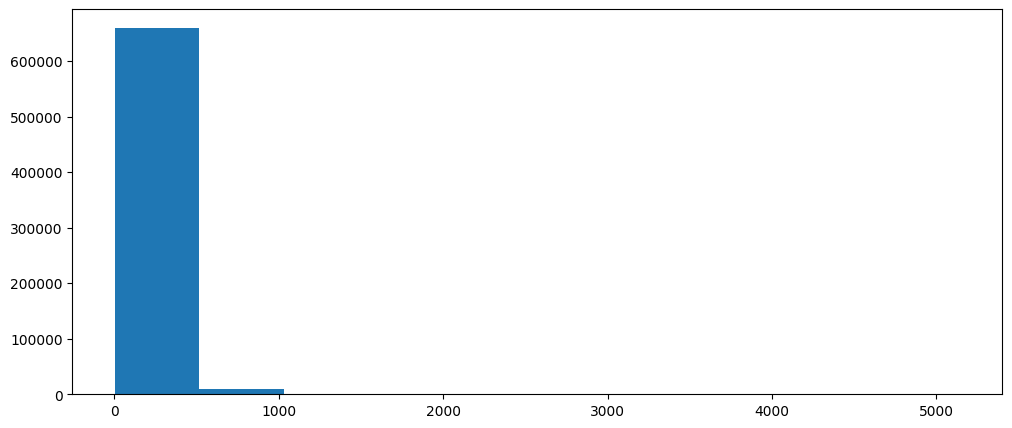

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(text_lens);

#### Get 95 Percentile for Text Length

In [ ]:
output_seq_len = int(np.percentile(text_lens, 95))
output_seq_len

317

95% of the sentences in our training set have a length of 317 tokens or less.

#### Maximum Text Length in Training Texts

In [ ]:
max(text_lens)

5144

#### Removing Symbols

In [ ]:
idx = random.randint(0, len(df)-1)
before_process = df.iloc[idx][0]

def process(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    x = re.sub('\s+', ' ', x)
    x = re.sub('\n+', ' ', x)
    return x.lower().strip()

df['reviewText'] = df['reviewText'] .progress_apply(lambda x: process(x))
after_process = df.iloc[idx][0]

100%|██████████| 838944/838944 [01:24<00:00, 9926.75it/s]


#### Removing Stopwords

In [ ]:
sw_set = set(nltk.corpus.stopwords.words('english'))

def sw_remove(x):
    words = nltk.tokenize.word_tokenize(x)
    filtered_list = [word for word in words if word not in sw_set]
    return ' '.join(filtered_list)

df['reviewText'] = df['reviewText'].progress_apply(lambda x: sw_remove(x))
after_removal = sw_remove(after_process)

100%|██████████| 838944/838944 [06:06<00:00, 2290.41it/s]


#### Checking Results

In [ ]:
print('Original Text:')
before_process

Original Text:


"I used this for a new build and it works great. This is my second computer with a SSD as the boot drive and I'm never going back. I can boot from blank to fully logged in in less than 30 seconds. Outstanding!"

In [ ]:
print('After First Process:')
after_process

After First Process:


'i used this for a new build and it works great this is my second computer with a ssd as the boot drive and i m never going back i can boot from blank to fully logged in in less than 30 seconds outstanding'

In [ ]:
print('After Removing Stopwords:')
after_removal

After Removing Stopwords:


'used new build works great second computer ssd boot drive never going back boot blank fully logged less 30 seconds outstanding'

#### Splitting Further Preprocessed Data

In [ ]:
text_train, text_validation, target_train, target_validation = train_test_split(df['reviewText'], df['overall'], test_size=0.2, random_state=42)

In [ ]:
np.random.seed(42)
nMax = 55000
udf = df.groupby('overall').progress_apply(lambda x: x.sample(n=min(nMax, len(x))))
udf = udf.rename(columns={'overall': 'label'}).reset_index()
utext_train, utext_validation, utarget_train, utarget_validation = train_test_split(udf['reviewText'], udf['label'], test_size=0.2, random_state=42)

100%|██████████| 5/5 [00:00<00:00, 20.63it/s]


In [ ]:
utext_train, utext_validation, utarget_train, utarget_validation = train_test_split(udf['reviewText'], udf['overall'], test_size=0.2, random_state=42)

In [ ]:
text_train = text_train.tolist()
text_validation  = text_validation.tolist()
utext_train = utext_train.tolist()
utext_validation = utext_validation.tolist()

In [ ]:
text_train [:7]

['camera year camera seems work fine since get attach camera grip handle tripod even find way attach lanyard waterproof case never able use wanted stick bike helmet business bought waterproof camera could use snorkel useless',
 'acer lcd monitor arrived almost week late unit packaged expected unit connected pc picture washed adjusting picture monitor controls easy updated video driver unit still exceptable unit ships cd helpful finally downloaded acer edisplay management software ran picture looked better debating returning unit',
 'upgraded standard hard drive ssd love world difference installing windows went ridiculously quickly like 10 minutes instead hour windows boots 15 seconds instead minute everything loads starts silky smooth breathed new life otherwise felt like old aging laptop',
 'first tablet ever bought specs good laggy sure also hard time connecting google play account game playing ultimately decided wanted smaller tablet return',
 'purchased convert fire hd 10 tablet la

In [ ]:
text_lens = [len(sentence.split()) for sentence in text_train]
text_lens_avg = np.mean(text_lens)
text_lens_avg

58.25811325252736

In [ ]:
output_seq_len = int(np.percentile(text_lens, 95))
output_seq_len

160

#### Tokenizing

In [ ]:
len(set((' '.join(df['reviewText'])).split(' ')))

278951

In [ ]:
dict_size = 70000
tokenizer = Tokenizer(num_words=dict_size)
tokenizer.fit_on_texts(df['reviewText'])

print('\033[1m' + 'Dictionary size:' + '\033[0m', dict_size)
print('\033[1m' + 'Length of the tokenizer index:' + '\033[0m', len(tokenizer.word_index))
print('\033[1m' + 'Number of documents the tokenizer was trained on:' + '\033[0m', tokenizer.document_count, '\n')
print('\033[1m' + 'First 20 entries of the tokenizer index:' + '\033[0m')
print(*list(tokenizer.word_index.items())[:20])

Dictionary size: 70000
Length of the tokenizer index: 278950
Number of documents the tokenizer was trained on: 838944 

First 20 entries of the tokenizer index:
('one', 1) ('use', 2) ('great', 3) ('like', 4) ('would', 5) ('good', 6) ('well', 7) ('get', 8) ('work', 9) ('works', 10) ('sound', 11) ('quality', 12) ('also', 13) ('case', 14) ('time', 15) ('really', 16) ('product', 17) ('camera', 18) ('cable', 19) ('using', 20)


In [ ]:
text_train_tokens = tokenizer.texts_to_sequences(text_train)
text_validation_tokens = tokenizer.texts_to_sequences(text_validation)
utext_train_tokens = tokenizer.texts_to_sequences(utext_train)
utext_validation_tokens = tokenizer.texts_to_sequences(utext_validation)
seq_lengths =  np.array([len(sequence) for sequence in text_train_tokens])
useq_lengths =  np.array([len(sequence) for sequence in utext_train_tokens])

The value of upper_bound is 184 and the percentage of sequences in "text_train_tokens" of length smaller or equal than upper_bound is 96.32%.


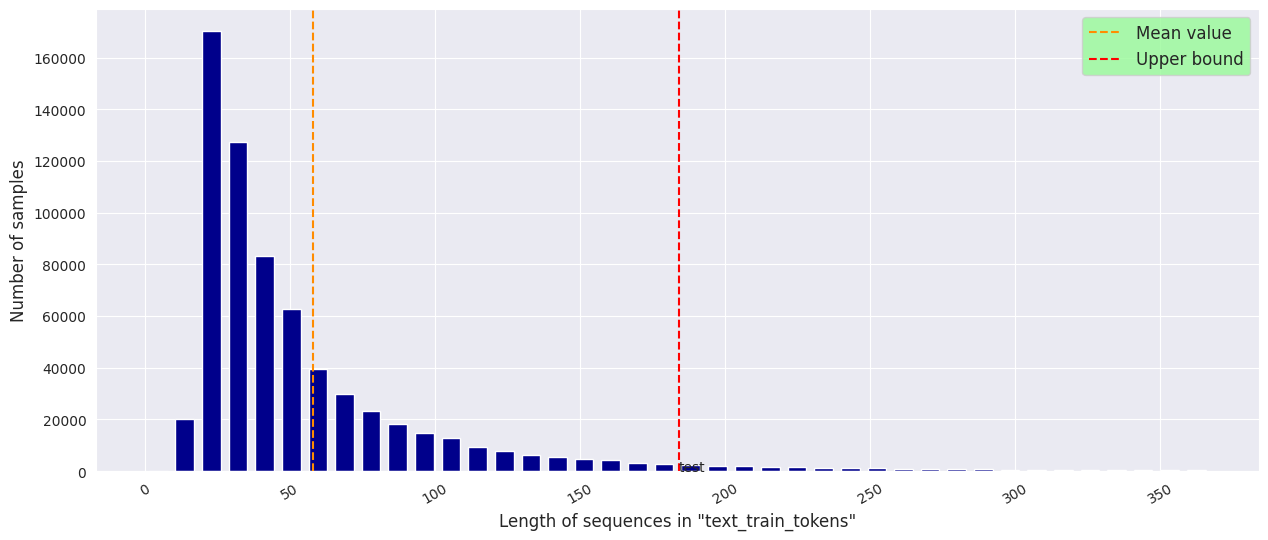

In [ ]:
upper_bound = int(np.mean(seq_lengths) + 2 * np.std(seq_lengths))
percentage = stats.percentileofscore(seq_lengths, upper_bound)

print('The value of upper_bound is %d and the percentage of sequences in "text_train_tokens" \
of length smaller or equal than upper_bound is %.2f%%.' % (upper_bound, round(percentage, 2)))

# Histogram plot of the lengths of the sequences in "text_train_tokens"

with sns.axes_style("darkgrid"):

    _, hist = plt.subplots(figsize=(15,6))
    hist.hist(seq_lengths[seq_lengths < 2*upper_bound], color='darkblue', bins=40, rwidth=0.7)
    hist.axvline(np.mean(seq_lengths), color='darkorange', linestyle='--', label='Mean value')
    hist.axvline(upper_bound, color='r', linestyle='--', label='Upper bound')

    plt.xlabel('Length of sequences in "text_train_tokens"', size='large')
    plt.ylabel('Number of samples', size='large')
    plt.text(upper_bound, 0, 'test')
    plt.legend(fontsize='large', facecolor='palegreen')
    plt.xticks(rotation=30)
    plt.show()

#### Adding Padding

In [ ]:
text_train_pad = pad_sequences(text_train_tokens, maxlen=upper_bound)
text_validation_pad = pad_sequences(text_validation_tokens, maxlen=upper_bound)
utext_train_pad = pad_sequences(utext_train_tokens, maxlen=upper_bound)
utext_validation_pad = pad_sequences(utext_validation_tokens, maxlen=upper_bound)

print('\033[1m' + 'text_train_pad.shape:' + '\033[0m', text_train_pad.shape)
print('\033[1m' + 'text_validation_pad.shape:' + '\033[0m', text_validation_pad.shape, '\n')

# Printing an example of review after padding
idx_pad = random.randint(0, len(text_train_pad)-1)
print('\033[1m' + 'Review #%d after padding:' %idx_pad + '\033[0m' + '\n', text_train_pad[idx_pad])

text_train_pad.shape: (671155, 184)
text_validation_pad.shape: (167789, 184) 

Review #464196 after padding:
 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0  

#### Label Encoding

##### Chaning Label Range
from [1, 5] to [0, 4]

In [ ]:
target_train = target_train.progress_apply(lambda l: l-1)
target_validation = target_validation.progress_apply(lambda l: l-1)
utarget_train = utarget_train.progress_apply(lambda l: l-1)
utarget_validation = utarget_validation.progress_apply(lambda l: l-1)

100%|██████████| 55000/55000 [00:00<00:00, 466770.24it/s]


In [ ]:
one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_one_hot = one_hot_encoder.fit_transform(target_train.to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(target_validation.to_numpy().reshape(-1, 1))

In [ ]:
one_hot_encoder = OneHotEncoder(sparse_output=False)

utrain_labels_one_hot = one_hot_encoder.fit_transform(utarget_train.to_numpy().reshape(-1, 1))
uval_labels_one_hot = one_hot_encoder.transform(utarget_validation.to_numpy().reshape(-1, 1))

#### Tensorflow Dataset

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((text_train, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((text_validation, val_labels_one_hot))
utrain_dataset = tf.data.Dataset.from_tensor_slices((utext_train, utrain_labels_one_hot))
uvalid_dataset = tf.data.Dataset.from_tensor_slices((utext_validation, uval_labels_one_hot))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
utrain_dataset = utrain_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
uvalid_dataset = uvalid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Model 2: Pretrained Token Embeddings

#### Model

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(text_train)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
device works great paired three devices iphone ipad android phone easy switch devices remember number assigned chose via likeliness need type via keyboard device one complaint weight thought would weigh much less guessing counter balance weight tablet holder

Sentence after embedding:
[-0.06809349 -0.01822367 -0.05056971  0.02026556  0.06920361 -0.00238356
  0.05090966 -0.02076915  0.0196671  -0.01750088 -0.01535495 -0.04256458
  0.03409055  0.01767218 -0.07253649  0.0562178   0.02134928  0.00444535
 -0.01349217  0.04228682  0.0363973   0.00485974 -0.01722044 -0.04530314
  0.02928058  0.07277907  0.01660049  0.04730983 -0.01562409 -0.03113249] (truncated output)...

Length of sentence embedding:
512


In [ ]:
def model_2():
  inputs = layers.Input(shape=[], dtype=tf.string)
  pretrained_embedding = tf_hub_embedding_layer(inputs)
  x = layers.Dense(128, activation="relu")(pretrained_embedding)
  outputs = layers.Dense(5, activation="softmax")(x)
  model_2 = tf.keras.Model(inputs=inputs,
                          outputs=outputs)

  model_2.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])
  return model_2

In [ ]:
model_2().summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_25 (Dense)            (None, 128)               65664     
                                                                 
 dense_26 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


#### Base Data

In [ ]:
model_2_base = model_2()

In [ ]:
model_2_base.fit(train_dataset,
            steps_per_epoch=int(0.3 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.3 * len(valid_dataset)))

Epoch 1/3
6292/6292 [==============================] - 179s 28ms/step - loss: 1.0228 - accuracy: 0.6043 - val_loss: 0.9969 - val_accuracy: 0.6130
Epoch 2/3
6292/6292 [==============================] - 169s 27ms/step - loss: 0.9950 - accuracy: 0.6126 - val_loss: 0.9833 - val_accuracy: 0.6195
Epoch 3/3
6292/6292 [==============================] - 179s 29ms/step - loss: 0.9813 - accuracy: 0.6186 - val_loss: 0.9789 - val_accuracy: 0.6216


In [ ]:
model_2_pred_probs = model_2_base.predict(valid_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)

5244/5244 [==============================] - 107s 20ms/step


In [ ]:
model_2_cr = classification_report(target_validation, model_2_preds)
print(model_2_cr)

              precision    recall  f1-score   support

           0       0.50      0.62      0.55     16572
           1       0.32      0.03      0.06     11347
           2       0.29      0.19      0.23     16109
           3       0.44      0.18      0.25     31292
           4       0.69      0.92      0.79     92469

    accuracy                           0.62    167789
   macro avg       0.45      0.39      0.38    167789
weighted avg       0.56      0.62      0.56    167789



#### Undersampled Data

In [ ]:
model_2_u = model_2()

In [ ]:
model_2_u.fit(utrain_dataset,
            steps_per_epoch=int(1 * len(utrain_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(1 * len(uvalid_dataset)))

Epoch 1/3
6875/6875 [==============================] - 192s 28ms/step - loss: 1.3114 - accuracy: 0.4260 - val_loss: 1.2414 - val_accuracy: 0.4944
Epoch 2/3
6875/6875 [==============================] - 180s 26ms/step - loss: 1.2752 - accuracy: 0.4449 - val_loss: 1.2107 - val_accuracy: 0.5076
Epoch 3/3
6875/6875 [==============================] - 181s 26ms/step - loss: 1.2552 - accuracy: 0.4548 - val_loss: 1.2023 - val_accuracy: 0.5089


In [ ]:
umodel_2_pred_probs = model_2_u.predict(uvalid_dataset)
umodel_2_preds = tf.argmax(umodel_2_pred_probs, axis=1)

1719/1719 [==============================] - 33s 19ms/step


In [ ]:
umodel_2_cr = classification_report(utarget_validation, umodel_2_preds)
print(umodel_2_cr)

              precision    recall  f1-score   support

           0       0.53      0.63      0.57     10965
           1       0.37      0.24      0.29     10863
           2       0.34      0.39      0.36     11057
           3       0.40      0.40      0.40     10974
           4       0.56      0.57      0.57     11141

    accuracy                           0.45     55000
   macro avg       0.44      0.45      0.44     55000
weighted avg       0.44      0.45      0.44     55000



### Model 3: Using LSTM Layer

In [30]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding , LSTM , Dense , SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import F1Score


In [26]:
df['overall'] = df['overall'].progress_apply(lambda l: l-1)

100%|██████████| 838944/838944 [00:01<00:00, 474131.15it/s]


In [29]:
udf['label'] = udf['label'].progress_apply(lambda l: l-1)

100%|██████████| 275000/275000 [00:00<00:00, 281312.78it/s]


In [35]:
def model_3():
  model = Sequential()
  model.add(Embedding(input_dim = max_words , output_dim = 128 , input_length= max_len))
  model.add(SpatialDropout1D(0.2))
  model.add(LSTM(100))
  model.add(Dense(5 , activation = 'softmax'))

  model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = [F1Score(average = 'micro')])

  return model

#### Base

In [33]:
texts = df['reviewText']
labels = df['overall']

max_words = 1000
max_len = 200
tokenizer = Tokenizer(num_words = max_words, oov_token = '')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen = max_len, padding='post', truncating='post')

labels_categorical = tf.keras.utils.to_categorical(labels)

X_train, X_validation, y_train, y_validation = train_test_split(padded_sequences, labels_categorical, test_size = 0.2, random_state = 42)

In [36]:
model_3_base = model_3()
model_3_base.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_data = (X_validation, y_validation))

Epoch 1/10
20974/20974 [==============================] - 298s 14ms/step - loss: 1.0445 - f1_score: 0.6084 - val_loss: 0.8095 - val_f1_score: 0.6814
Epoch 2/10
20974/20974 [==============================] - 293s 14ms/step - loss: 0.7759 - f1_score: 0.6924 - val_loss: 0.7503 - val_f1_score: 0.7040
Epoch 3/10
20974/20974 [==============================] - 250s 12ms/step - loss: 0.7323 - f1_score: 0.7089 - val_loss: 0.7189 - val_f1_score: 0.7151
Epoch 4/10
20974/20974 [==============================] - 249s 12ms/step - loss: 0.7110 - f1_score: 0.7162 - val_loss: 0.7172 - val_f1_score: 0.7165
Epoch 5/10
20974/20974 [==============================] - 265s 13ms/step - loss: 0.6972 - f1_score: 0.7214 - val_loss: 0.7052 - val_f1_score: 0.7184
Epoch 6/10
20974/20974 [==============================] - 283s 14ms/step - loss: 0.6881 - f1_score: 0.7244 - val_loss: 0.7007 - val_f1_score: 0.7211
Epoch 7/10
20974/20974 [==============================] - 264s 13ms/step - loss: 0.6808 - f1_score: 0.7276

In [40]:
model_3_pred_probs = model_3_base.predict(X_validation)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)

5244/5244 [==============================] - 25s 4ms/step


In [43]:
model_3_cr = classification_report(tf.argmax(y_validation, axis=1), model_3_preds)
print(model_3_cr)

              precision    recall  f1-score   support

           0       0.59      0.78      0.67     16572
           1       0.43      0.26      0.32     11347
           2       0.47      0.40      0.43     16109
           3       0.60      0.45      0.52     31292
           4       0.83      0.92      0.87     92469

    accuracy                           0.72    167789
   macro avg       0.59      0.56      0.56    167789
weighted avg       0.70      0.72      0.71    167789



In [39]:
model_3_base.save("/content/drive/MyDrive/Data/quera/LSTM_base_unprocessed")

#### Undersmapled Data

In [44]:
texts = udf['reviewText']
labels = udf['label']

max_words = 1000
max_len = 200
tokenizer = Tokenizer(num_words = max_words, oov_token = '')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen = max_len, padding='post', truncating='post')

labels_categorical = tf.keras.utils.to_categorical(labels)

X_train, X_validation, y_train, y_validation = train_test_split(padded_sequences, labels_categorical, test_size = 0.2, random_state = 42)

In [45]:
model_3_u = model_3()
model_3_u.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_data = (X_validation, y_validation))

Epoch 1/10
6875/6875 [==============================] - 107s 15ms/step - loss: 1.5861 - f1_score: 0.2359 - val_loss: 1.3665 - val_f1_score: 0.3563
Epoch 2/10
6875/6875 [==============================] - 92s 13ms/step - loss: 1.2080 - f1_score: 0.4618 - val_loss: 1.1048 - val_f1_score: 0.5262
Epoch 3/10
6875/6875 [==============================] - 84s 12ms/step - loss: 1.0788 - f1_score: 0.5333 - val_loss: 1.0468 - val_f1_score: 0.5492
Epoch 4/10
6875/6875 [==============================] - 109s 16ms/step - loss: 1.0309 - f1_score: 0.5573 - val_loss: 1.0268 - val_f1_score: 0.5568
Epoch 5/10
6875/6875 [==============================] - 86s 13ms/step - loss: 0.9987 - f1_score: 0.5699 - val_loss: 1.0064 - val_f1_score: 0.5668
Epoch 6/10
6875/6875 [==============================] - 84s 12ms/step - loss: 0.9734 - f1_score: 0.5813 - val_loss: 1.0003 - val_f1_score: 0.5724
Epoch 7/10
6875/6875 [==============================] - 80s 12ms/step - loss: 0.9531 - f1_score: 0.5902 - val_loss: 0.9943

In [46]:
model_3_u.save("/content/drive/MyDrive/Data/quera/LSTM_u_unprocessed")

In [50]:
umodel_3_pred_probs = model_3_u.predict(X_validation)
umodel_3_preds = tf.argmax(umodel_3_pred_probs, axis=1)

1719/1719 [==============================] - 12s 7ms/step


In [51]:
umodel_3_cr = classification_report(tf.argmax(y_validation, axis=1), umodel_3_preds)
print(umodel_3_cr)

              precision    recall  f1-score   support

           0       0.63      0.67      0.65     10965
           1       0.46      0.46      0.46     10863
           2       0.50      0.46      0.48     11057
           3       0.57      0.53      0.55     10974
           4       0.69      0.75      0.72     11141

    accuracy                           0.58     55000
   macro avg       0.57      0.58      0.57     55000
weighted avg       0.57      0.58      0.57     55000



#### Processing Data

In [47]:
def process(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    x = re.sub('\s+', ' ', x)
    x = re.sub('\n+', ' ', x)
    return x.lower().strip()

sw_set = set(nltk.corpus.stopwords.words('english'))

def sw_remove(x):
    words = nltk.tokenize.word_tokenize(x)
    filtered_list = [word for word in words if word not in sw_set]
    return ' '.join(filtered_list)

In [52]:
df['reviewText'] = df['reviewText'] .progress_apply(lambda x: process(x))
df['reviewText'] = df['reviewText'].progress_apply(lambda x: sw_remove(x))

udf['reviewText'] = udf['reviewText'] .progress_apply(lambda x: process(x))
udf['reviewText'] = udf['reviewText'].progress_apply(lambda x: sw_remove(x))

100%|██████████| 275000/275000 [02:57<00:00, 1551.22it/s]


#### Base Processed

In [53]:
texts = df['reviewText']
labels = df['overall']

max_words = 1000
max_len = 200
tokenizer = Tokenizer(num_words = max_words, oov_token = '')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen = max_len, padding='post', truncating='post')

labels_categorical = tf.keras.utils.to_categorical(labels)

X_train, X_validation, y_train, y_validation = train_test_split(padded_sequences, labels_categorical, test_size = 0.2, random_state = 42)

In [55]:
model_3_base_processed = model_3()
model_3_base_processed.fit(X_train, y_train, epochs = 4, batch_size = 32, validation_data = (X_validation, y_validation))

Epoch 1/4
20974/20974 [==============================] - 317s 15ms/step - loss: 1.1157 - f1_score: 0.5901 - val_loss: 0.8954 - val_f1_score: 0.6558
Epoch 2/4
20974/20974 [==============================] - 286s 14ms/step - loss: 0.8626 - f1_score: 0.6651 - val_loss: 0.8388 - val_f1_score: 0.6744
Epoch 3/4
20974/20974 [==============================] - 288s 14ms/step - loss: 0.8269 - f1_score: 0.6790 - val_loss: 0.8143 - val_f1_score: 0.6830
Epoch 4/4
20974/20974 [==============================] - 319s 15ms/step - loss: 0.8066 - f1_score: 0.6864 - val_loss: 0.8042 - val_f1_score: 0.6876


In [56]:
model_3_base_processed.save("/content/drive/MyDrive/Data/quera/LSTM_base_processed")

In [57]:
pmodel_3_pred_probs = model_3_base_processed.predict(X_validation)
pmodel_3_preds = tf.argmax(pmodel_3_pred_probs, axis=1)

5244/5244 [==============================] - 26s 5ms/step


In [58]:
pmodel_3_cr = classification_report(tf.argmax(y_validation, axis=1), pmodel_3_preds)
print(pmodel_3_cr)

              precision    recall  f1-score   support

           0       0.62      0.64      0.63     16572
           1       0.43      0.19      0.27     11347
           2       0.46      0.28      0.35     16109
           3       0.57      0.39      0.46     31292
           4       0.75      0.93      0.83     92469

    accuracy                           0.69    167789
   macro avg       0.57      0.49      0.51    167789
weighted avg       0.65      0.69      0.66    167789



## Test Prediction

In [10]:
!gdown 1-Cb-kBGlVW6PPX4bR7IeZyU1lB0WoW2K

Downloading...
From: https://drive.google.com/uc?id=1-Cb-kBGlVW6PPX4bR7IeZyU1lB0WoW2K
To: /content/test_data.csv
100% 15.6M/15.6M [00:00<00:00, 108MB/s] 


In [15]:
test = pd.read_csv('test_data.csv')
test = test['reviewText']
test

0        The name and description of this device are mi...
1        One of the molex connectors on the power suppl...
2        Remote constantly disconnects/ Roku player fre...
3        I purchased this 4 year protection plan for a ...
4        I bought one of these and have regretted it ev...
                               ...                        
19995    I've just had it up and running for 3 days, bu...
19996    Looking for high quality audio interconnect ca...
19997    Perfect! Does exactly as told. The cable is a ...
19998    I bought this for my dell latitude e6330. I wa...
19999    <div id="video-block-R14LAKU3P9UVQP" class="a-...
Name: reviewText, Length: 20000, dtype: object

In [16]:
max_words = 1000
max_len = 200
tokenizer = Tokenizer(num_words = max_words, oov_token = '')
tokenizer.fit_on_texts(test)
sequences = tokenizer.texts_to_sequences(test)
padded_sequences = pad_sequences(sequences, maxlen = max_len, padding='post', truncating='post')

In [19]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Data/quera/LSTM_base_unprocessed')

In [20]:
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 128)          128000    
                                                                 
 spatial_dropout1d_2 (Spati  (None, 200, 128)          0         
 alDropout1D)                                                    
                                                                 
 lstm_2 (LSTM)               (None, 100)               91600     
                                                                 
 dense_2 (Dense)             (None, 5)                 505       
                                                                 
Total params: 220105 (859.79 KB)
Trainable params: 220105 (859.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
preds_probs = loaded_model.predict(padded_sequences)
preds = tf.argmax(preds_probs, axis=1)
preds

625/625 [==============================] - 8s 4ms/step


<tf.Tensor: shape=(20000,), dtype=int64, numpy=array([4, 2, 4, ..., 0, 4, 3])>

In [29]:
preds_df = pd.DataFrame({'predicted': preds.numpy()})
preds_df

,predicted
0,4
1,2
2,4
3,4
4,4
...,...
19995,4
19996,0
19997,0
19998,4


In [30]:
preds_df['predicted'] = preds_df['predicted'].progress_apply(lambda l: l+1)
preds_df

100%|██████████| 20000/20000 [00:00<00:00, 504350.40it/s]


,predicted
0,5
1,3
2,5
3,5
4,5
...,...
19995,5
19996,1
19997,1
19998,5


In [31]:
preds_df.to_csv('q2_submission.csv', index=False)